In [55]:
from collections import Counter
from dotenv import load_dotenv
from hyppo.ksample import Energy
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import re
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, mannwhitneyu
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
twitter_accounts_df = pd.read_csv("twitter_human_bots_dataset.csv", index_col=0)
twitter_translated_embeddings_df = pd.read_csv("twitter_translated_embeddings.csv")

In [5]:
twitter_accounts_df

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37433,2009-08-08 13:11:15,True,False,"Role: Stock Taker. Past Roles: Nanny, Sales As...",651,139,1105,False,63963107,en,Kingston Upon Hull,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/5844684414...,butchsekab,340,False,0.084,4028,human
37434,2013-01-05 21:35:37,False,False,KINGDOM LANDLORD #FreeCornBread,8839,1121486,605,True,1064042478,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9511349456...,Mathieu_Era,24970,True,8.976,2782,human
37435,2013-01-14 18:05:54,True,False,Bienvenid@s al Twitter Oficial de Sergio Dalma...,399,85630,190,False,1089732602,it,En constante movimiento,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1174733822...,SDalmaoficial,6174,True,2.226,2773,human
37436,2012-09-10 16:12:02,False,False,Just a good guy wrapped up in a bad system.\nA...,967,138,166,True,815529979,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme14/bg.gif,http://pbs.twimg.com/profile_images/1265807908...,VinceYearly,982,False,0.339,2899,human


In [33]:
bot_indices = twitter_accounts_df["account_type"]=="bot"
human_indices = twitter_accounts_df["account_type"]=="human"

# Hypothesis 1: Bots have a lower follower-to-friend ratio compared to human accounts
Bots are often used to artificially boost engagement or amplify content visibility. To appear active and legitimate, they tend to follow large numbers of accounts, including both other bots and real users. This can explain why many bots also have high follower counts these are often other bots within coordinated networks.
However, bots generally lack reciprocation from real users because their mass-following behavior is easily recognizable as suspicious or inauthentic. As a result, their follower-to-friend ratio remains significantly lower than that of human accounts, reflecting their one-sided and automated interaction patterns.

In [ ]:
twitter_accounts_df["followers_friends_ratio"] = twitter_accounts_df["followers_count"] / twitter_accounts_df["friends_count"]

/Users/han-ying/Downloads/DSA4263 - twitter/twitter_bots_env/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


followers_friends_ratio
inf            5376
0.000000        221
1.000000         85
0.500000         64
0.333333         59
               ... 
3528.268145       1
602.938852        1
1.043967          1
1.221818          1
450.684211        1
Name: count, Length: 26700, dtype: int64

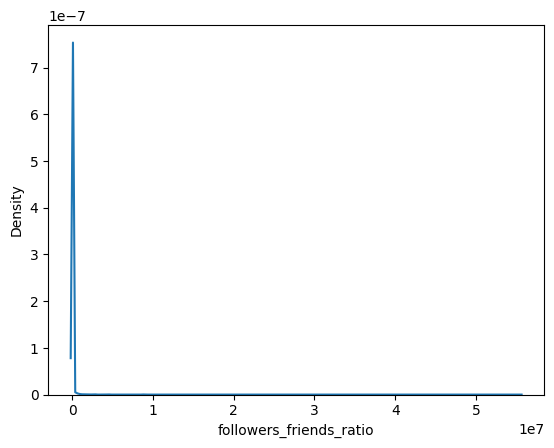

In [20]:
sns.kdeplot(x=twitter_accounts_df["followers_friends_ratio"])
twitter_accounts_df["followers_friends_ratio"].value_counts()

Many accounts have inifinite or extremely large follower-to-friend ratios due to 0 friend/follwoer counts. To handle this, the ratio was transformed as log((followers+1)/(friends+1))

In [24]:
twitter_accounts_df["log_followers_friends_ratio"] = np.log((twitter_accounts_df["followers_count"] + 1) / (twitter_accounts_df["friends_count"] + 1))

<Axes: xlabel='log_followers_friends_ratio', ylabel='Density'>

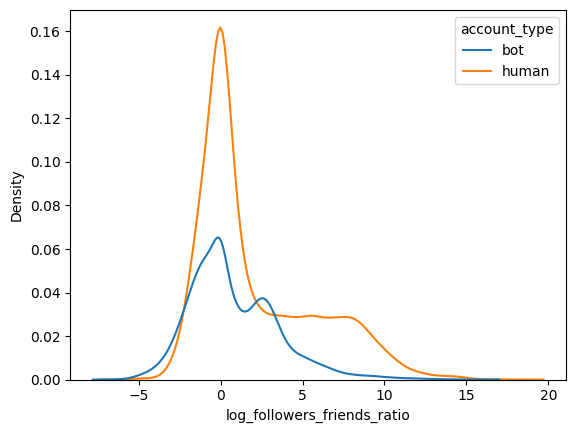

In [25]:
sns.kdeplot(data=twitter_accounts_df, x="log_followers_friends_ratio", hue="account_type")

Since `log_followers_friends_ratio` is not normally distributed, test for statistical significance using non-parametric the Mann-Whitney U test.

In [36]:
bots_ratio = twitter_accounts_df["log_followers_friends_ratio"][bot_indices]
humans_ratio = twitter_accounts_df["log_followers_friends_ratio"][human_indices]
stat, p = mannwhitneyu(bots_ratio, humans_ratio, alternative="two-sided")
print(f"Mann-Whitney U p-value: {p}")

Mann-Whitney U p-value: 4.2987536059436695e-207


p-value is observed to be <0.05 which means the difference is statistically significant, hence we can support the hypothesis that bots tend to follow more users while having far fewer followers.

# Hypothesis 2: Bots and humans use distinct language patterns in their profile descriptions.

Profile descriptions reflect how users present themselves on Twitter. Human users typically write with personalized, expressive, and varied language, whereas bots often employ generic, templated, or keyword-driven text to appear relevant or to advertise specific content.

## Method
To assess whether profile-language differs systematically between bots and humans we used both token-level and representation-level analyses.

### Token-Level:
At the token level, we ran:
1. Chi-square tests on individual n-grams to identify terms with significantly different frequency between groups
2. Log-odds with informative Dirichlet priors (LODP) to estimate effect sizes and rank n-grams by how strongly they associate with each class

### Representation-level:
At the representation level, we embedded each profile description with a pretrained sentence encoder and performed
3. Mann–Whitney U test on per-account embedding similarity / projection scores to compare central tendencies
4. Energy distance test to compare the full multivariate embedding distributions between the two groups.


In [41]:
def custom_preprocessor(text):
    """
    Remove translated pattern from descriptions that were translated to english.
    Normalize  by replacing handles and URLs with placeholders, lowercase and lemmatize.
    """
    translated_pattern = r"'translation_text': '([^']*)'"
    match = re.search(translated_pattern, text)
    if match:
        text = match[1]

    # replace URLs with placeholder
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # remove newlines, tabs, and extra spaces
    text = re.sub(r"[\n\t]+", " ", text)
    text = re.sub(r"\s+", " ", text)

    text = text.lower().strip()

    stop_words = set(nltk.corpus.stopwords.words("english"))
    filtered = [word for word in text.split() if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in filtered]
    return " ".join(lemmatized)

In [42]:
# preprocess translated user descriptions and impute missing values with empty string
twitter_translated_embeddings_df["description_en"] = twitter_translated_embeddings_df["description_en"].fillna("")
twitter_translated_embeddings_df["description_en"] = twitter_translated_embeddings_df["description_en"].apply(custom_preprocessor)

## Token-Level

### 1. Chi-Square Test on n-gram

In [45]:
# obtain n-gram counts
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=5)  # or based on your threshold
vectorizer.fit(twitter_translated_embeddings_df["description_en"].tolist())

bot_matrix = vectorizer.transform(twitter_translated_embeddings_df[twitter_translated_embeddings_df.account_type == "bot"]["description_en"])
human_matrix = vectorizer.transform(twitter_translated_embeddings_df[twitter_translated_embeddings_df.account_type == "human"]["description_en"])

bot_counts = np.asarray(bot_matrix.sum(axis=0)).flatten()
human_counts = np.asarray(human_matrix.sum(axis=0)).flatten()

total_bot = bot_counts.sum()
total_human = human_counts.sum()

ngram_df = pd.DataFrame({
    "ngram": vectorizer.get_feature_names_out(),
    "bot_freq": bot_counts,
    "human_freq": human_counts
})

ngram_df["bot_norm"] = ngram_df["bot_freq"] / total_bot
ngram_df["human_norm"] = ngram_df["human_freq"] / total_human


# chi-square test on each n-gram
chi2_vals = []
p_vals = []

for i, (ngram, bot_freq, human_freq, _, _) in ngram_df.iterrows():
    chi2, p, _, _ = chi2_contingency([
    [bot_freq, human_freq],
    [total_bot - bot_freq, total_human - human_freq]
])
    chi2_vals.append(chi2)
    p_vals.append(p)

ngram_df["chi2"] = chi2_vals
ngram_df["p"] = p_vals

# filter significant n-grams
ngram_df[ngram_df["p"] <= 0.05].sort_values(by="p")

,ngram,bot_freq,human_freq,bot_norm,human_norm,chi2,p
652,bot,333,15,0.008315,0.000112,1038.652389,7.125039e-228
1072,come,450,124,0.011237,0.000923,997.469080,6.373784e-219
5880,trading,256,36,0.006392,0.000268,688.790247,8.191560e-152
6201,waiting,210,18,0.005244,0.000134,613.178570,2.277227e-135
926,check,263,88,0.006567,0.000655,534.074890,3.668097e-118
...,...,...,...,...,...,...,...
5830,time bestselling,0,17,0.000000,0.000127,3.851879,4.969030e-02
5337,slytherin,0,17,0.000000,0.000127,3.851879,4.969030e-02
3691,mayor,0,17,0.000000,0.000127,3.851879,4.969030e-02
3986,nbcnews,0,17,0.000000,0.000127,3.851879,4.969030e-02


### 2. Log Odds Ratio with Informative Dirichlet Prior (LODP)

- identify characteristic words that distinguish the language used in human profile and bot profile descriptions
- LODP calculates the log odds ratio of term frequencies between 2 corpora, while incorporating a prior (combined) distribution of word frequencies to account for potential biases and to smooth estimates

reference: https://antonio-velazquez-bustamante.medium.com/comparing-political-speeches-with-python-and-nlp-54cd506e91b9

In [46]:
def lodp(corpus1, corpus2, prior_corpus, alpha=0.01):
    def descriptions_to_tokens(corpus):
        return [token for desc in corpus for token in word_tokenize(desc)]
    
    tokens1 = descriptions_to_tokens(corpus1)
    tokens2 = descriptions_to_tokens(corpus2)
    prior_tokens = descriptions_to_tokens(prior_corpus)

    term_count_corpus1 = Counter(tokens1)
    term_count_corpus2 = Counter(tokens2)
    term_count_prior = Counter(prior_tokens)

    vocab = set(term_count_corpus1) | set(term_count_corpus2) | set(term_count_prior)
    n_terms = len(vocab)

    term_indices = {term: i for i, term in enumerate(vocab)}

    counts1 = np.zeros(n_terms)
    counts2 = np.zeros(n_terms)
    prior_counts = np.zeros(n_terms)
 
    # Count occurrences of each unique word
    for term, count in term_count_corpus1.items():
        counts1[term_indices[term]] = count

    for term, count in term_count_corpus2.items():
        counts2[term_indices[term]] = count

    for term, count in term_count_prior.items():
        prior_counts[term_indices[term]] = count

    n1 = counts1.sum()
    n2 = counts2.sum()
    nprior = prior_counts.sum()

    # Calculate the smoothed word counts in the two corpora using a Dirichlet prior.
    counts1 += alpha * prior_counts
    counts2 += alpha * prior_counts

    # Compute the log odds ratio for each word by taking the difference of the logarithms of the smoothed counts for each corpus, normalized by their respective total counts.
    log_odds = np.log(counts1) - np.log(counts1.sum()) - np.log(counts2) + np.log(counts2.sum())
    
    # Calculate the variance for each word using the inverse of the smoothed counts.
    variance = 1 / counts1 + 1 / counts2

    # Compute the z-scores by dividing the log odds ratios by the square root of the variances.
    z_scores = log_odds / np.sqrt(variance)

    return {term: z_scores[i] for term, i in term_indices.items()}


def plot_top_words(z_scores, n=10):
    sorted_terms = sorted(z_scores, key=z_scores.get)
    top_positive_terms = sorted_terms[-n:]
    top_negative_terms = sorted_terms[:n]

    top_positive_scores = [z_scores[term] for term in top_positive_terms]
    top_negative_scores = [z_scores[term] for term in top_negative_terms]

    fig, ax = plt.subplots()

    y_pos = np.arange(n)

    ax.barh(y_pos, top_positive_scores, align='center', color='blue', label='Human Corpus')
    ax.barh(-y_pos - 1, top_negative_scores, align='center', color='red', label='Bot Corpus')

    ax.set_yticks(np.hstack((y_pos, -y_pos - 1)))
    ax.set_yticklabels(top_positive_terms + top_negative_terms)
    ax.invert_yaxis()

    ax.set_xlabel('Z-Scores')
    ax.set_title('Top Words by Log Odds Ratio with Informative Dirichlet Prior')
    ax.legend()

    plt.show()

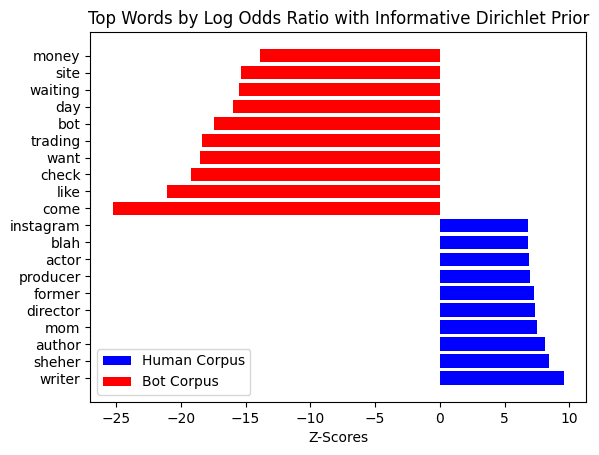

In [47]:
prior_corpus = twitter_translated_embeddings_df.description_en.tolist()
human_corpus = twitter_translated_embeddings_df[human_indices].description_en.tolist()
bot_corpus = twitter_translated_embeddings_df[bot_indices].description_en.tolist()

zscores = lodp(human_corpus, bot_corpus, prior_corpus)
plot_top_words(zscores)

Interpreting Z scores
- Larger |z|: difference between occurrence of a word in human and bot corpora is more significant
- Positive z: Word is more common in human profile descriptions
- Negative z: Word is more common in bot profile descriptions

## Non-parametric Distributional Test on Text Embeddings

### 3. Mann-Whitney U Test

Null hypothesis (H₀): There is no difference between embedding dimension i for bot and human accounts. 

Alternative hypothesis (H₁): There is a difference between embedding dimension i for bot and human accounts. 

In [51]:
# run this to obtain embeddings 

load_dotenv()

def embed_descriptions(description_df):
    
    model = SentenceTransformer('all-MiniLM-L6-v2', token=os.getenv("HF_API_KEY"))
    embeddings_lst = []

    for i, row in description_df.iterrows():
        if row["description_en"]:
            embeddings = model.encode(row["description_en"])
        else:
            embeddings = np.zeros(384, dtype=float)  # default dim=384
        embeddings_lst.append(embeddings)

        if not i % 1000:
            print(f"progress: {i}")

    description_df["description_en_embeddings"] = embeddings_lst
    
    return description_df

twitter_translated_embeddings_df = embed_descriptions(twitter_translated_embeddings_df)

progress: 0
progress: 1000
progress: 2000
progress: 3000
progress: 4000
progress: 5000
progress: 6000
progress: 7000
progress: 8000
progress: 9000
progress: 10000
progress: 11000
progress: 12000
progress: 13000
progress: 14000
progress: 15000
progress: 16000
progress: 17000
progress: 18000
progress: 19000
progress: 20000
progress: 21000
progress: 22000
progress: 23000
progress: 24000
progress: 25000
progress: 26000
progress: 27000
progress: 28000
progress: 29000
progress: 30000
progress: 31000
progress: 32000
progress: 33000
progress: 34000
progress: 35000
progress: 36000
progress: 37000


In [52]:
def transpose_embeddings(embeddings_df):
    embeddings = np.vstack(embeddings_df.values)
    return embeddings.T

def mannwhitneyu_test(human_embeddings_df, bot_embeddings_df):
    human_embeddings_T = transpose_embeddings(human_embeddings_df)
    bot_embeddings_T = transpose_embeddings(bot_embeddings_df)
    dims = human_embeddings_T.shape[0]
    
    results = {"dimension": [], "statistic": [], "p": []}

    for dim in range(dims):
        human_sample = human_embeddings_T[dim]
        bot_sample = bot_embeddings_T[dim]
        statistic, p_value = mannwhitneyu(human_sample, bot_sample, alternative='two-sided')
        
        results["dimension"].append(dim)
        results["statistic"].append(statistic)
        results["p"].append(p_value)
    
    return pd.DataFrame(results).sort_values(by="p")

human_embeddings_df = twitter_translated_embeddings_df[human_indices].description_en_embeddings
bot_embeddings_df = twitter_translated_embeddings_df[bot_indices].description_en_embeddings
mannwhitney_df = mannwhitneyu_test(human_embeddings_df, bot_embeddings_df)

alpha = 0.05 / mannwhitney_df.shape[0]  # Bonferroni correction
significant_dims = mannwhitney_df[mannwhitney_df["p"] <= alpha]

In [53]:
significant_dims

,dimension,statistic,p
319,319,111689169.0,0.000000e+00
223,223,119048578.0,0.000000e+00
351,351,192506666.0,0.000000e+00
99,99,191745187.0,0.000000e+00
157,157,188960493.0,1.155398e-266
...,...,...,...
138,138,159232326.5,6.606003e-05
8,8,151561475.0,6.819844e-05
253,253,159209031.5,7.313900e-05
237,237,159154549.5,9.259776e-05


### 4. Energy Distance Test
Null hypothesis (H₀): The embeddings of human and bot descriptions come from the same distribution in semantic space. There is no significant difference in the overall embedding structure between bots and humans.

Alternative hypothesis (H₁): The embeddings of human and bot descriptions are drawn from different distributions. Implies bots and humans use linguistically or semantically distinct patterns in their profile descriptions.

In [56]:
# Samppling to reduce compute time
size = 5000
idx_human = np.random.choice(human_embeddings_df.values.shape[0], size, replace=False)
idx_bot = np.random.choice(bot_embeddings_df.values.shape[0], size, replace=False)

human_embeddings_sample = np.vstack(human_embeddings_df.iloc[idx_human])
bot_embeddings_sample = np.vstack(bot_embeddings_df.iloc[idx_bot])

# Energy test
stat, pval = Energy().test(human_embeddings_sample, bot_embeddings_sample, reps=100)
print(f"test-statistic: {stat}")
print(f"p-value: {pval}")

/Users/han-ying/Downloads/DSA4263 - twitter/twitter_bots_env/lib/python3.13/site-packages/hyppo/tools/common.py:204: RuntimeWarning: The number of replications is low (under 1000), and p-value calculations may be unreliable. Use the p-value result, with caution!
  warnings.warn(msg, RuntimeWarning)


test-statistic: 0.04144163340088491
p-value: 1.4994752164770953e-137


Based on the Mann-Whitney U Test on each of the embedding dimension, there are 308 / 384 dimensions that differ significantly.

Combined with ther results of the energy distance test, which implies that the embeddings of human and bot descriptions are frawn from different distributions, we can conclude that bots and humans use linguistically or semantically distinct patterns in their profile descriptions